# Distance Estimation and Angle Recovery

<div class="alert alert-danger" role="alert">
  <p><strong>Important:</strong> This notebook is used to run the distance estimation on noisy data only (no angle recovery).</p>
  <hr>
    - <b>To enable GPU</b>: Navigate to Edit→Notebook Settings<br/>
    - <b>To save the latest version of code from this notebook</b>: Navigate to File→Save a copy to Github.
</div>

## Content

1. [Data Preparation](#1.-Data-Preparation)
2. [Distance Estimation](#2.-Distance-Estimation)
3. [Angle Recovery](#3.-Angle-Recovery)
4. [Angle Alignment](#4.-Angle-Alignment)

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](https://github.com/JelenaBanjac/protein-reconstruction/blob/master/notebooks/2-phase2/figures/5j0n.pdb1-500.jpg?raw=1)

In [0]:
# create directories
!mkdir --parents data/5j0n
!mkdir training

## Setup Environment (Colab)

Link to MiniConda Linux installer [here](https://docs.conda.io/en/latest/miniconda.html).

In [3]:
!wget -c https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local

--2020-06-16 18:25:06--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  81.12M   187MB/s    in 0.4s    

2020-06-16 18:25:07 (187 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
  

In [4]:
# save the model on the drive
from google.colab import drive
drive.mount("/content/drive")
#!cd 'drive/My Drive'
!mkdir --parents 'drive/My Drive/ModelsProtein'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
# clone repo
!rm -r protein-reconstruction
!git clone https://github.com/JelenaBanjac/protein-reconstruction.git
!cd protein-reconstruction

rm: cannot remove 'protein-reconstruction': No such file or directory
Cloning into 'protein-reconstruction'...
remote: Enumerating objects: 392, done.
remote: Counting objects: 100% (392/392), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 2249 (delta 266), reused 206 (delta 118), pack-reused 1857
Receiving objects: 100% (2249/2249), 257.94 MiB | 31.99 MiB/s, done.
Resolving deltas: 100% (1387/1387), done.


In [6]:
#!conda env create -f environment.yml 
!conda install -q -y --prefix /usr/local -c conda-forge ipyvolume
!pip3 install tensorflow-graphics-gpu

Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ipyvolume


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    attrs-19.3.0               |             py_0          35 KB  conda-forge
    backcall-0.1.0             |             py_0          13 KB  conda-forge
    bleach-3.1.5               |     pyh9f0ad1d_0         112 KB  conda-forge
    bqplot-0.12.12             |     pyh9f0ad1d_0         3.7 MB  conda-forge
    ca-certificates-2020.4.5.2 |       hecda079_0         147 KB  conda-forge
    certifi-2020.4.5.2         |   py37hc8dfbb8_0         152 KB  conda-forge
    cloudpickle-1.4.1          |             py_0          24 KB  conda-forge
    conda-4.8.3                |   py37hc8dfbb8_1         3.0 MB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    cytoolz-0.

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')
sys.path.append("protein-reconstruction") 

In [8]:
!python --version

Python 3.7.6


## Start the Pipeline

In [9]:
import os
import h5py
import numpy as np
import time
import pandas as pd


from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
import ipyvolume as ipv
from collections import Counter
import itertools
import seaborn as sns; sns.set(style="white", color_codes=True)
import io

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
tf.__version__

'2.2.0'

In [11]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12357990444317381825
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9669797929116192486
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
PROTEIN="5j0n"
NUM_PROJECTIONS = 5000

path_logs_training = "/content/drive/My Drive/ModelsProtein"
training_description = f"cosine4"

In [13]:
# TODO: dataset name
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(path_logs_training, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [14]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [15]:
angles_true = data['Angles']
angles_true.shape

(5000, 3)

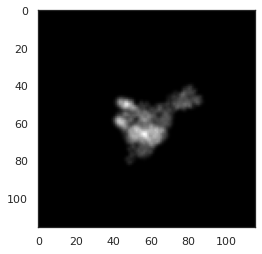

In [16]:
sampleProj = projections[1,:,:]
plt.imshow(sampleProj,cmap='gray')
plt.show()

In [0]:
#plot_images(angles_true, projections, range(100), img_size_scale=0.05)

In [0]:
#ipv.screenshot()

---

## Prepare for training

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

#### Global standardization of projections

In [0]:
from cryoem.distance_estimation import global_standardization

In [22]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [0]:
test_size = 0.33
val_size = 0.25

In [24]:
print(f"TRAIN: {1-test_size:.2f} x {1-val_size:.2f} = {(1-test_size)*(1-val_size):.2f} => {str(int((1-test_size)*(1-val_size)*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*(1-val_size)*5000, 2))).rjust(10)}")
print(f"TEST : {str(test_size).rjust(18)} => {str(int(test_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power(test_size*5000, 2))).rjust(10)}")
print(f"VAL  : {1-test_size:.2f} x {val_size:.2f} = {(1-test_size)*val_size:.2f} => {str(int((1-test_size)*val_size*5000)).rjust(5)} imgs => max pairs: {str(int(np.power((1-test_size)*val_size*5000, 2))).rjust(10)}")

TRAIN: 0.67 x 0.75 = 0.50 =>  2512 imgs => max pairs:    6312656
TEST :               0.33 =>  1650 imgs => max pairs:    2722500
VAL  : 0.67 x 0.25 = 0.17 =>   837 imgs => max pairs:     701406


In [0]:
data = np.load(f"{path_logs_training}/5j0n_siamese_idx.npz")
train_idx, val_idx, test_idx = data["arr_0"], data["arr_1"], data["arr_2"]

In [0]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [27]:
X.shape

(5000, 116, 116, 1)

# 1. Distance Estimation

### Train the model

In [0]:
from time import time

In [0]:
# UNIFORM
from tensorflow.keras.utils import Sequence

num_dec = 1
num_bins = 32

# # for weights
# dQ_values = np.load("data/5j0n/dQ_values_100K.npy")
# distribution = np.histogram(dQ_values, bins=32, range=(0.0, np.pi), density=True)
# probabilities = distribution[0]
# weights = 1/probabilities
# weights_norm = weights/sum(weights)

class DataGenerator(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        start_time = time()
        if batch_size > limit_num_pairs:
            raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
        self.X = X  
        self.y = y  
        self.limit_num_pairs = limit_num_pairs
        self.list_ids = list_ids
        self.batch_size = batch_size  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs:
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
        
        if limit_style=="uniform":
            self.pair_ids = self._generate_uniform()
      
        self.shuffle = shuffle 
        self._on_epoch_start()
        print(f"Data created in {time()-start_time} sec")
        
        
    def _generate_uniform(self):
        if os.path.exists(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
            return np.load(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
        else:
            bins = {}
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                bins[np.around(i, num_dec)] = []


            for idx1, idx2 in self.pair_ids:
                label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
                bins[np.around(label, num_dec)].append([idx1, idx2])

            min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
            print("min=", min_bin_size)
            if min_bin_size == 0:
                raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


            # cut the top of histogram to make it uniform
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                b = np.around(i, num_dec)
                bins[b] = np.take(bins[b], np.arange(min_bin_size), axis=0)  

            l = np.array(list(itertools.chain(*list(bins.values()))))
            np.save(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
            print("total number of data = ", 31*min_bin_size)
            return l
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1)  # shape: (len(idx1), 2, x.shape[1], x.shape[2], x.shape[3])
        labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))  # shape: len(idx1)

        #weights = np.array(self._get_weights(labels))
        #labels_and_weights = np.stack((labels, weights), axis=1)
        
        # [training_pairs[:, 0], training_pairs[:, 1]], labels
        return [pairs[:, 0], pairs[:, 1]], labels 
        
    #def _get_weights(self, labels):
    #    l = labels.numpy()
    #    return np.array(list(map(lambda x: probabilities[np.where(x >= distribution[1])[0][-1]], l)))    
    
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)     

In [0]:
import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.rotation_matrices import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE

_idx1 = list(np.random.choice(val_idx, size=1000))
_idx2 = list(np.random.choice(val_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in _idx1])
q2_true = euler2quaternion([angles_true[i] for i in _idx2])

p1 = [X[i] for i in _idx1]
p2 = [X[i] for i in _idx2]

model = None

def cosine_distance(vests):
    x, y = vests
    xy_sum_square = K.sum(x * y, axis=1, keepdims=True) 
    xx_sum_square = K.sum(x * x, axis=1, keepdims=True)
    xx_sum_square = K.maximum(xx_sum_square,  1e-08) 
    yy_sum_square = K.sum(y * y, axis=1, keepdims=True)
    yy_sum_square = K.maximum(yy_sum_square, 1e-08) 
    
    cos_theta = tf.divide(xy_sum_square, K.sqrt(xx_sum_square)*K.sqrt(yy_sum_square))
    eps = K.epsilon()
    return 2*tf.acos(tf.clip_by_value(cos_theta, 0.0+eps, 1.0-eps)) 

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    return MAE(y_true, y_pred) 

def mse(y_true, y_pred):
    return MSE(y_true, y_pred) 


def create_siamese_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    #x = AvgPool2D(pool_size=[8, 8], padding='same')(x)
    #x = tf.squeeze(x, axis=[1,2])
    x = Flatten()(x)
    x = Dense(4)(x)

    return Model(input_x, x)


def train_siamese(X, y, train_idx, val_idx, epochs, batch_size, learning_rate, limit_style, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None):
    
    
    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        
        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            dP_values = d_p(p1, p2).T[0]
            dQ_values = d_q(q1_true, q2_true).numpy()

            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        # Prepare data generators
        training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps, limit_style=limit_style, shuffle=True)
        validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps, limit_style=limit_style, shuffle=True)
        
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)
        
        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

        global model
        model = Model([input_a, input_b], distance)  # was m

        # train
        #model = multi_gpu_model(m, gpus=gpus)
        model.summary()
        #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        # training only top layers
        optimizer1 = RMSprop(learning_rate=learning_rate)
        model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)

        # Setup callbacks
        # Callback that saves the model
        training_description = training_description or strftime('%Y%m%d_%H%M%S')
        CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
        pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
        backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        print(f"Model will be saved to: {CHECKPOINT_PATH}")
        # Callback that will show tensorboard data
        LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
        # Callback for the dP/dQ plot
        file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
        plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot))
        # Callback that will decrease LR if it gets plateau in val_loss
        #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)



        history1 = model.fit(training_generator, 
                            epochs=epochs,
                            validation_data=validation_generator, 
                            callbacks=[plot_callback, logs_callback, backup_callback])
        
        # Get training and test loss histories
        training_loss = history1.history['loss']
        val_loss = history1.history['val_loss']
        mses = history1.history['mse']
        val_mses = history1.history['val_mse']
        pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
        np.savez(f"{path_logs_training}/losses/{training_description}.npz", training_loss, val_loss, mses, val_mses)

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            plt.show();

        return model, history1

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

In [30]:
# 0.1 -> 34 min/epoch
# 0.01 -> 3.3 min/epoch
train_percent = 0.01
val_percent = 0.01
int(train_percent*np.power(len(train_idx), 2)), int(val_percent*np.power(len(val_idx), 2))

(63101, 7022)

In [0]:
model, history1 = train_siamese(X=X, y=y, 
                               train_idx=train_idx, 
                               val_idx=val_idx,
                               epochs=150,  #500
                               batch_size=256,  #512 latest 
                               learning_rate=1e-3,  #0.01 
                                limit_style="random", 
                                path_logs_training=path_logs_training, 
                                training_description=training_description,
                               training_steps=int(train_percent*np.power(len(train_idx), 2)),  # None
                               validation_steps=int(val_percent*np.power(len(val_idx), 2)),  # None
                               plot=True,
                               gpus=None)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Data created in 4.829856634140015 sec
Data created in 0.5168235301971436 sec
Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4)            4553988     input_1[0][0]                    
                                                                 input_2[0][0]

---

In [1]:
data = np.load(f"{path_logs_training}/losses/{training_description}.npz")
training_loss, val_loss, mses, val_mses = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]

NameError: ignored

In [0]:
# Get training and test loss histories
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
plt.show();

In [0]:
training_loss[-1], val_loss[-1], mses[-1], val_mses[-1]

### (Or) Read model checkpoint

In [0]:
# put correct filename
model_filename = f"{path_logs_training}/training/{training_description}.h5"

In [31]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 4)            4553988     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

---

## dP/dQ plot

In [0]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [0]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=256)

In [0]:
# 5:41 with 1024
# 5:43     with 256
idx1 = list(np.random.choice(test_idx, size=1000))
idx2 = list(np.random.choice(test_idx, size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

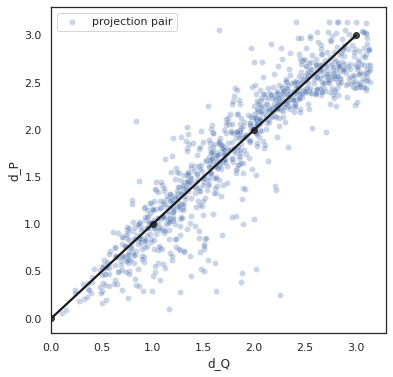

<Figure size 432x288 with 0 Axes>

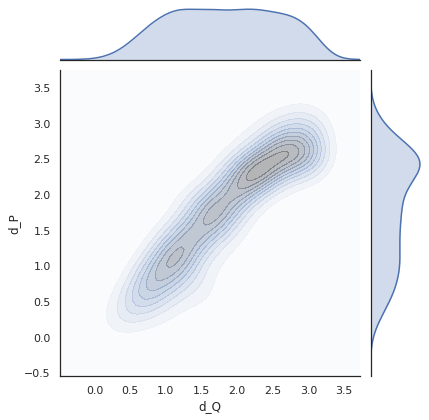

Variance = 0.3016571361291492
Min. angle recovery loss possible = 0.09090603074986243


In [35]:
plot_dP_dQ(dP_values, dQ_values)

In [0]:
MAE(dQ_values, dP_values)